# Featuer Engineering

## Part 1: Data Merging WITH preserving NaNs

In [ ]:
# define root directory
import warnings
import re
import pandas as pd
import datetime


root_directory = 'C:\\Users/manue\\switchdrive\\Mutual Funds Project\\data\\predictors\\raw'

In [ ]:
import glob
sub_directories = glob.glob("C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\predictors\\raw\\*")


In [ ]:
# get path to each file in each subdirectory
filepath = []
from os import walk
for folder in sub_directories:
    files = next(walk(folder), (None, None, []))[2]  # [] if no file
    for file in files:
        filepath.append(folder + '\\' + file)

In [ ]:
import calendar

# get all monthly dates
years = range(1980,2023,1)
months = range(1,13,1)

last_day_of_month = []
for year in years:
    for month in months:
        first, last = calendar.monthrange(year, month)
        last_day_of_month.append(datetime.datetime(year, month, last).date())
        

In [ ]:
last_day_of_month = last_day_of_month[0:140]

In [ ]:
warnings.filterwarnings('ignore')

regex = re.compile('(?s:.*){}(.*){}'.format(re.escape('\\'), re.escape('.csv')))

funds_IDs = list(pd.read_excel('C:/Users/manue/switchdrive/Mutual Funds Project/data/investment_list.xlsx')[0])

for date in last_day_of_month:
    print(date)
    string_date_format1 = date.strftime('%d/%m/%Y')
    string_date_format2 = date.strftime('%Y-%m-%d')
    monthly_df = pd.DataFrame(index= funds_IDs)
    for file in filepath:
        #print(file)
        var_name = regex.findall(file)[0]
        
        variable_file = pd.read_csv(file, index_col = 'SecId')
        variable_file = variable_file.loc[variable_file.index.dropna()] #drop rows with no Fund ID
        variable_file = variable_file[~variable_file.index.duplicated(keep='first')] #drop duplicate entries
        if len(variable_file.columns) > 50: #we ignore data that are only available on a yearly basis
            try:
                variable_file = pd.DataFrame(variable_file.loc[:,string_date_format1])
                variable_file.rename(columns={string_date_format1: var_name}, inplace = True)
                monthly_df = pd.concat([monthly_df, variable_file], axis=1)

            except KeyError:
                variable_file = pd.DataFrame(variable_file.loc[:,string_date_format2])
                variable_file.rename(columns={string_date_format2: var_name}, inplace = True)
                monthly_df = pd.concat([monthly_df, variable_file], axis=1)
    monthly_df.dropna(how='all', inplace = True)
    monthly_df['date'] = string_date_format2
    monthly_df.to_csv('C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\features_new\\' + string_date_format2 + ".csv", header=True, index=True,)

        


## Part 2: Merging all months to single dataset

In [ ]:
import os

# specify the directory path
dir_path = 'C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\features_new\\'

# get all file names in the directory
single_datasets = os.listdir(dir_path)


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np

#subset1 = single_datasets[0:300]
#subset2 = single_datasets[300:380]
#subset3 = single_datasets[380:450]
subset4 = single_datasets[511:]
#subsets = [subset1, subset2, subset3, subset4]

for i in range(0,4):
    subset = subsets[i]
    
    #read all CSVs
    all_CSVs_subset = [pd.read_csv(dir_path+str(file)) for file in subset4]
    df_sub = pd.concat(all_CSVs_subset)
    
    #drop artificial index and fundIDs
    #df_sub = df_sub.iloc[:,0:]
    df_sub.rename(columns={'Unnamed: 0':'SecID'}, inplace=True)
    df_sub.dropna(subset=['returns'], inplace = True)
    df_sub = df_sub.replace(',', '', regex=True)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np

subset1 = single_datasets[0:300]
subset2 = single_datasets[300:380]
subset3 = single_datasets[380:450]
subset4 = single_datasets[450:]
subsets = [subset1, subset2, subset3, subset4]

for i in range(0,4):
    subset = subsets[i]
    
    #read all CSVs
    all_CSVs_subset = [pd.read_csv(dir_path+str(file)) for file in subset]
    df_sub = pd.concat(all_CSVs_subset)
    
    #rename SecID col and drop rows without a returun
    df_sub.rename(columns={'Unnamed: 0':'SecID'}, inplace=True)
    df_sub.dropna(subset=['returns'], inplace = True)
    #replace commas
    df_sub = df_sub.replace(',', '', regex=True)
    
    #converting data types to less memory intensive formats
    temp = pd.concat([
        df_sub.select_dtypes([], ['float64']),
        df_sub.select_dtypes(['float64']).apply(pd.Series.astype, dtype='float16')
        ], axis=1)

   
    
    #all floats are converted to float16 except the ones below where we use float 32 to prevent 'infs'
    temp.Rating = temp.Rating.astype('float32')
    temp.returns = df_sub.returns.astype('float32')
    temp.Eq_Market_Value = df_sub.Eq_Market_Value.astype('float32') 
    temp.Total_Market_Value_Long = df_sub.Total_Market_Value_Long.astype('float32')
    temp.Total_Market_Value_Net = df_sub.Total_Market_Value_Net.astype('float32')
    temp.Total_Market_Value_Short  = df_sub.Total_Market_Value_Short.astype('float32')
    temp.Estimated_FundLevel_Net_Flow_Monthly_Comprehensive = df_sub.Estimated_FundLevel_Net_Flow_Monthly_Comprehensive.astype('float32')
    temp.Fund_Size_Monthly_Comprehensive = df_sub.Fund_Size_Monthly_Comprehensive.astype('float32')
    temp['Redemptions_FundLevel_N-PORT'] = df_sub['Redemptions_FundLevel_N-PORT'].astype('float32')
    temp['Reinvested_Dividends_FundLevel_N-PORT'] = df_sub['Reinvested_Dividends_FundLevel_N-PORT'].astype('float32')
    temp['Sales_FundLevel_N-PORT'] = df_sub['Sales_FundLevel_N-PORT'].astype('float32')
    temp.Info_Ratio_arith_1y  = df_sub.Info_Ratio_arith_1y.astype('float32')
    temp.Info_Ratio_arith_2y = df_sub.Info_Ratio_arith_2y.astype('float32')
    temp.Avg_Mkt_Cap_Mil_Long = df_sub.Avg_Mkt_Cap_Mil_Long.astype('float32')
    
    #treat SecID and date differently
    temp.SecID = temp.SecID.astype('category')
    temp.date = temp.date.astype('category')
    
    #convert all remaining objects
    temp = pd.concat([
        temp.select_dtypes([], ['object']),
        temp.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')], axis=1)
    
    #convert SecID and date back
    temp.SecID = temp.SecID.astype('object')
    temp.date = pd.to_datetime(temp['date'])
        
        
    

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    newdf = temp.select_dtypes(include=numerics)
    print(newdf.columns.to_series()[np.isinf(newdf).any()]) # safety check to ensure no floats to 'infs' converted

    # compare how much memory is saved
    print('BEFORE CONVERTING')
    print(df_sub.info())
    print('AFTER CONVERTING\n\n')
    print(temp.info())
    
    #save to pickle file
    temp.to_pickle(f'C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\pickle_files\\test_{i+1}.pkl') 
     

In [ ]:
import pandas as pd
DFs = [pd.read_pickle(f"C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\pickle_files\\test_{1+i}.pkl") for i in range(0,4)]
merged = pd.concat(DFs)
merged.to_pickle('C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\pickle_files\\full_dataset.pkl')




### Read in Data

### Domicile Information

In [ ]:
import os

# specify the directory path
dir_path_countries = 'C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\fund_country_info\\raw_downloads\\'

# get all file names in the directory
single_datasets = os.listdir(dir_path_countries)

 #read all CSVs
single_excel = [pd.read_excel(dir_path_countries+str(file)) for file in single_datasets]
country_information = pd.concat(single_excel)

In [ ]:
country_information = country_information.reset_index(drop=True)
country_information

In [ ]:
country_information.Domicile

In [ ]:
# create a histogram of the counts of unique values in the 'color' column
counts = country_information['Domicile'].value_counts()
counts_df = pd.DataFrame(counts)
counts_df

In [ ]:
# plot a histogram
import matplotlib.pyplot as plt

# create a bar chart with custom figure size and rotated tick labels
fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(counts_df.index, counts_df.Domicile, alpha = 0.3)

# add labels and title
ax.set_title('Counts of Fund Domicile', fontsize = 15)
ax.yaxis.grid(True, which='major', color='grey', linestyle='-', alpha=0.5)

# set y-axis to logarithmic scale
#ax.set_yscale('log')

#ax.set_ylabel('Quantity')
#ax.set_title('Fruit Quantity')
# customize tick labels
ax.tick_params(axis='x', rotation=90)
#fig.suptitle('Average relative amount of column values available per month', fontsize=14)
fig.savefig('domiciles.eps', dpi=300, bbox_inches='tight')

### Try to infer country by allocation data

In [13]:
# Step 1: read in SecID list

ids = pd.read_excel(r'C:\Users\manue\switchdrive\Mutual Funds Project\data\investment_list.xlsx', header = None)
ids

,0
0,F0GBR056R3
1,F0GBR04P1G
2,F000002CT6
3,F0GBR04QYI
4,F0000023NW
...,...
24120,F0GBR053DN
24121,F0GBR04QTD
24122,F00000WC0Z
24123,F000015O3W


In [2]:
data_countries = data.filter(like='SecID' and 'Eq_Country')
data_countries['SecID'] = data.SecID
data_countries

C:\Users\manue\AppData\Local\Temp\ipykernel_14164\2929564668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_countries['SecID'] = data.SecID


,Eq_Country_Australia_Net,Eq_Country_Brazil_Net,Eq_Country_Canada_Net,Eq_Country_China_Net,Eq_Country_France_Net,Eq_Country_Germany_Net,Eq_Country_Hong_Kong_Net,Eq_Country_Italy_Net,Eq_Country_Japan_Net,Eq_Country_Mexico_Net,...,Eq_Country_Pakistan_Net,Eq_Country_Peru_Net,Eq_Country_Philippines_Net,Eq_Country_Portugal_Net,Eq_Country_Singapore_Net,Eq_Country_Slovakia_Net,Eq_Country_Turkey_Net,Eq_Country_Venezuela_Net,Eq_Country_Vietnam_Net,SecID
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOUSA00BH9
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F0GBR06HWW
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOUSA00FQB
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F0GBR04DD8
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FOUSA00C6V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3737290,0.0,92.875000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,F00000ZBDK
3737291,0.0,0.000000,2.650391,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,F0GBR04QTD
3737292,0.0,0.000000,0.000000,3.320312,0.0,5.160156,6.359375,0.0,4.039062,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,F00000WC0Z
3737293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F000015O3W


In [4]:
data_countries.columns

Index(['Eq_Country_Australia_Net', 'Eq_Country_Brazil_Net',
       'Eq_Country_Canada_Net', 'Eq_Country_China_Net',
       'Eq_Country_France_Net', 'Eq_Country_Germany_Net',
       'Eq_Country_Hong_Kong_Net', 'Eq_Country_Italy_Net',
       'Eq_Country_Japan_Net', 'Eq_Country_Mexico_Net',
       'Eq_Country_Netherlands_Net', 'Eq_Country_Norway_Net',
       'Eq_Country_Other_Countries_Net', 'Eq_Country_Poland_Net',
       'Eq_Country_Russia_Net', 'Eq_Country_South_Africa_Net',
       'Eq_Country_South_Korea_Net', 'Eq_Country_Spain_Net',
       'Eq_Country_Sweden_Net', 'Eq_Country_Switzerland_Net',
       'Eq_Country_Taiwan_Net', 'Eq_Country_Thailand_Net',
       'Eq_Country_United_Kingdom_Net', 'Eq_Country_United_States_Net',
       'Eq_Country_India_Net', 'Eq_Country_Argentina_Net',
       'Eq_Country_Austria_Net', 'Eq_Country_Belgium_Net',
       'Eq_Country_Chile_Net', 'Eq_Country_Colombia_Net',
       'Eq_Country_Czech_Republic_Net', 'Eq_Country_Denmark_Net',
       'Eq_Country_Eston

In [18]:
data_countries[data_countries['SecID']=='F000015SFA'].to_excel('india_chf_fund.xlsx')

In [19]:
max_allocation_per_fund = data_countries.groupby('SecID').max().loc[list(ids[0])]



In [20]:
max_allocation_per_fund

,Eq_Country_Australia_Net,Eq_Country_Brazil_Net,Eq_Country_Canada_Net,Eq_Country_China_Net,Eq_Country_France_Net,Eq_Country_Germany_Net,Eq_Country_Hong_Kong_Net,Eq_Country_Italy_Net,Eq_Country_Japan_Net,Eq_Country_Mexico_Net,...,Eq_Country_New_Zealand_Net,Eq_Country_Pakistan_Net,Eq_Country_Peru_Net,Eq_Country_Philippines_Net,Eq_Country_Portugal_Net,Eq_Country_Singapore_Net,Eq_Country_Slovakia_Net,Eq_Country_Turkey_Net,Eq_Country_Venezuela_Net,Eq_Country_Vietnam_Net
SecID,,,,,,,,,,,,,,,,,,,,,
F0GBR056R3,21.406250,6.968750,18.234375,0.000000,7.390625,10.578125,0.970215,1.790039,19.312500,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
F0GBR04P1G,0.000000,0.000000,0.000000,0.000000,4.449219,4.511719,0.000000,0.000000,3.210938,0.000000,...,0.000000,0.000000,4.488281,0.000000,0.000000,2.330078,0.0,0.000000,0.0,0.0
F000002CT6,2.330078,4.660156,3.599609,6.308594,3.070312,2.830078,2.699219,1.059570,15.343750,1.190430,...,0.070007,0.010002,0.350098,0.389893,0.300049,1.219727,0.0,0.709961,0.0,0.0
F0GBR04QYI,0.040009,0.000000,0.000000,0.010002,95.250000,0.000000,0.000000,0.750000,0.020004,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
F0000023NW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F0GBR053DN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F0GBR04QTD,0.000000,4.000000,7.160156,0.000000,0.000000,0.000000,3.160156,0.000000,1.019531,4.628906,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.140625,0.0,0.000000,0.0,0.0
F00000WC0Z,1.240234,0.000000,4.601562,8.242188,4.769531,10.390625,6.671875,1.200195,4.199219,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [21]:
# define the threshold and the string to use when there is no value exceeding the threshold
threshold = 50
no_value_string = 'Diversified'

# create a function to find the column name where the max value exceeds the threshold
def find_max_column(row):
    max_value = row.max()
    if max_value >= threshold:
        return row.idxmax()[11:-4].replace('_',' ')
    else:
        return no_value_string

# apply the function to each row of the dataframe
result = max_allocation_per_fund.apply(find_max_column, axis=1)

# print the result
result

SecID
F0GBR056R3      Diversified
F0GBR04P1G           Norway
F000002CT6      Diversified
F0GBR04QYI           France
F0000023NW      Diversified
                  ...      
F0GBR053DN      Diversified
F0GBR04QTD    United States
F00000WC0Z    United States
F000015O3W        Singapore
F0GBR06B7N    United States
Length: 24125, dtype: object

In [22]:
diversified_funds = result[result == 'Diversified'].index.to_list()

# use the isin() method to check if each index value is in the list
mask = max_allocation_per_fund.index.isin(diversified_funds)

# filter the dataframe using the mask
diversified_max = pd.DataFrame(max_allocation_per_fund[mask].max(axis = 1))#.idxmax()

In [23]:
diversified_max = pd.DataFrame(max_allocation_per_fund[mask].max(axis = 1))#.idxmax()
diversified_max['country'] = max_allocation_per_fund[mask].idxmax(axis = 1).to_list()
diversified_max_is_nan = diversified_max[diversified_max[0].isna()]

diversified_max_is_nan_id = diversified_max_is_nan.index.to_list()
diversified_max_is_nan_id

['F0000023NW',
 'F0000020B0',
 'F00000MARH',
 'F00000OJ88',
 'FOUSA00NLC',
 'F00000UO5K',
 'F000000RQ8',
 'F000000IVP',
 'F00000LYY7',
 'FOUSA00NZA',
 'F0GBR06EVY',
 'F000005QB6',
 'F00000Y6R5',
 'F0GBR052IZ',
 'F000013HA9',
 'F00000WO74',
 'F00000VCH6',
 'F0GBR06QLZ',
 'F00000JT1J',
 'F00000PKUA',
 'F00000XICQ',
 'F0000025Z9',
 'F000015B0L',
 'F00000412N',
 'F00000U5OG',
 'F0GBR06CJQ',
 'FOUSA00NA4',
 'FOUSA00NMP',
 'F0GBR06TGN',
 'F0GBR04SB7',
 'F000010SBL',
 'F00000ZQA5',
 'F0GBR04CSJ',
 'F0GBR04CP8',
 'F00000TU5P',
 'F00000MB4I',
 'FOUSA00OJX',
 'F00000XLEI',
 'FOUSA00LTG',
 'F0GBR06OY8',
 'F000015SAC',
 'FOUSA00H1Y',
 'FOUSA00MHU',
 'F0GBR04QRY',
 'F00000NZHU',
 'F000000RW6',
 'FOUSA05BNB',
 'F00000T55A',
 'F00000XDZN',
 'F00000THQX',
 'F00000WSUN',
 'FOUSA00MQ6',
 'FOUSA00M0Q',
 'F00000T4PW',
 'F000010MAJ',
 'FOUSA00LZ3',
 'FOUSA05XTK',
 'F00000YVAB',
 'FOUSA00OHK',
 'F000000FEX',
 'F0000003LT',
 'F00000TOU2',
 'F00000WSU5',
 'FOUSA00MP5',
 'F00000Z42R',
 'FOUSA00P14',
 'F00000Q7

In [36]:
unknown_countries = pd.DataFrame(diversified_max_is_nan_id).set_index(0)
unknown_countries[0] = np.nan
unknown_countries.index = diversified_max_is_nan_id
unknown_countries

,0
F0000023NW,NaN
F0000020B0,NaN
F00000MARH,NaN
F00000OJ88,NaN
FOUSA00NLC,NaN
...,...
FOUSA00GSU,NaN
F000001UCU,NaN
F00000QT1T,NaN
F00000XGCN,NaN


In [24]:
results_df = pd.DataFrame(result)
results_df = results_df.drop(diversified_max_is_nan_id)

# create a histogram of the counts of unique values in the 'color' column
counts_country = results_df[0].value_counts()
counts_country_df = pd.DataFrame(counts_country)
counts_country_df

,0
Diversified,9222
United States,7101
United Kingdom,849
Japan,777
France,706
Brazil,647
India,627
China,579
Sweden,379
Switzerland,249


In [37]:
results_df_merged = pd.concat([results_df, unknown_countries])


,0
F0GBR056R3,Diversified
F0GBR04P1G,Norway
F000002CT6,Diversified
F0GBR04QYI,France
F0000162S3,China
...,...
FOUSA00GSU,NaN
F000001UCU,NaN
F00000QT1T,NaN
F00000XGCN,NaN


In [38]:
results_df_merged.to_excel('fund_country_invested_mapping.xlsx')

In [29]:
len(set(data.SecID))

24125

In [ ]:
# plot a histogram
import matplotlib.pyplot as plt

# create a bar chart with custom figure size and rotated tick labels
fig, ax = plt.subplots(figsize=(16, 4))
ax.bar(counts_country_df.index, counts_country_df[0], alpha = 0.3)

# add labels and title
ax.set_title('Counts of Fund Allocation', fontsize = 15)
ax.yaxis.grid(True, which='major', color='grey', linestyle='-', alpha=0.5)

# set y-axis to logarithmic scale
#ax.set_yscale('log')

#ax.set_ylabel('Quantity')
#ax.set_title('Fruit Quantity')
# customize tick labels
ax.tick_params(axis='x', rotation=90)
#fig.suptitle('Average relative amount of column values available per month', fontsize=14)
fig.savefig('country_allocation.eps', dpi=300, bbox_inches='tight')

In [ ]:
diversified_max

In [2]:
mask = data['date'].dt.year == int(2018)
data_sample = data[mask]
data_sample

,date,SecID,#_Stock_Holdings_Short,%_Asset_In_Top_10_Holdings,Cash_%_Net,Eq_Country_Australia_Net,Eq_Country_Brazil_Net,Eq_Country_Canada_Net,Eq_Country_China_Net,Eq_Country_France_Net,...,Eq_Type_Distressed_Net,Eq_Type_Other_Net,Eq_Type_Speculative_Growth_Net,Rating,returns,Portfolio_Corporate_Sustainability_Score,Eq_Stylebox_Long,Financial_Health_Grade_Long,Growth_Grade_Long,Profitability_Grade_Long
3074922,2018-01-31,F0GBR04P1G,0.0,99.750000,4.640625,0.0,0.000000,0.000000,0.000000,0.0000,...,NaN,NaN,NaN,3.0,0.0501,NaN,Mid Blend,C-,C-,C
3074923,2018-01-31,F00000U4SS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,0.0531,NaN,NaN,NaN,NaN,NaN
3074924,2018-01-31,FOUSA05HHU,0.0,3.609375,0.000000,0.0,0.010002,0.020004,0.000000,0.0000,...,7.921875,3.919922,8.570312,3.0,0.0263,39.68750,Small Growth,B-,C+,C-
3074925,2018-01-31,F00000NO5J,0.0,21.656250,3.859375,0.0,0.000000,0.000000,0.000000,93.9375,...,NaN,NaN,NaN,4.0,0.0821,NaN,Small Growth,NaN,C,C
3074926,2018-01-31,F000001GFX,0.0,43.968750,5.140625,0.0,0.000000,0.000000,0.000000,0.0000,...,NaN,NaN,NaN,5.0,0.0312,42.71875,Large Value,C-,C,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3222204,2018-12-31,F00000ZBDK,0.0,100.500000,-0.070007,0.0,85.125000,0.000000,0.000000,0.0000,...,NaN,NaN,NaN,NaN,0.0162,49.93750,Large Growth,C-,C-,C
3222205,2018-12-31,F0GBR04L29,0.0,36.437500,1.219727,0.0,11.500000,0.000000,25.109375,0.0000,...,NaN,NaN,NaN,3.0,-0.0119,46.65625,Large Growth,B-,B-,C
3222206,2018-12-31,F0GBR04QTD,NaN,36.406250,6.269531,0.0,0.000000,0.000000,0.000000,0.0000,...,0.000000,11.429688,13.671875,NaN,-0.0974,48.18750,Large Growth,A-,B-,C
3222207,2018-12-31,F00000WC0Z,NaN,40.375000,0.990234,0.0,0.000000,0.000000,0.850098,0.0000,...,0.000000,0.000000,0.000000,3.0,-0.0692,52.25000,Large Value,B+,C,C+


In [42]:
data[data['SecID'] == 'F00000X0FQ'].dropna(axis=1, how='all').columns

Index(['date', 'SecID', 'Alpha_1y', 'Alpha_2y', 'Sortino_Ratio_1y',
       'Estimated_FundLevel_Net_Flow_Monthly_Comprehensive',
       'Fund_Size_Monthly_Comprehensive', 'Info_Ratio_arith_1y',
       'Info_Ratio_arith_2y', 'Batting_Average_1y', 'Batting_Average_2y',
       'Beta_1y', 'Beta_2y', 'Excess_Return', 'Kurtosis_1y', 'Kurtosis_2y',
       'Max_Drawdown_1y', 'Max_Drawdown_2y', 'R2_1y', 'R2_2y',
       'Sharpe_Ratio_1y', 'Sharpe_Ratio_2y', 'Skewness_1y', 'Skewness_2y',
       'Sortino_Ratio_2y', 'Tracking_Error_1y', 'Tracking_Error_2y', 'Rating',
       'returns'],
      dtype='object')

In [3]:
data_sample = data_sample.select_dtypes(include=['float32', 'float64']).sample(100).dropna(axis=1, how='all')

data_sample

,Eq_Market_Value,Total_Market_Value_Long,Total_Market_Value_Net,Total_Market_Value_Short,Estimated_FundLevel_Net_Flow_Monthly_Comprehensive,Fund_Size_Monthly_Comprehensive,Redemptions_FundLevel_N-PORT,Reinvested_Dividends_FundLevel_N-PORT,Sales_FundLevel_N-PORT,Info_Ratio_arith_1y,Info_Ratio_arith_2y,Avg_Mkt_Cap_Mil_Long,Rating,returns
3200634,9.963760e+07,119907448.0,119907448.0,NaN,-7.496503e+05,119910224.0,NaN,NaN,NaN,-14.420000,NaN,11385.120117,NaN,-0.0395
3134730,5.968309e+07,63822104.0,63822104.0,NaN,4.885292e+05,63876020.0,NaN,NaN,NaN,-15.860000,-11.150000,58837.449219,2.0,0.0141
3118206,NaN,NaN,NaN,NaN,7.241200e+02,3292131.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,-0.0002
3108152,3.198170e+07,39963088.0,39963088.0,NaN,-3.170727e+05,39963088.0,NaN,NaN,NaN,NaN,NaN,70641.398438,NaN,-0.0206
3078914,1.879036e+08,282128832.0,282122720.0,6.104860e+03,5.297678e+06,282122720.0,NaN,NaN,NaN,0.350000,-2.650000,10354.280273,3.0,0.0553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3177956,5.752812e+09,729433984.0,729433984.0,NaN,7.633634e+06,729433984.0,NaN,NaN,NaN,-65.930000,0.050000,2686.229980,4.0,0.0451
3116085,3.881958e+07,51549880.0,48629284.0,2.920595e+06,-1.935881e+06,34001428.0,NaN,NaN,NaN,-142.580002,-48.860001,3290.979980,2.0,-0.0152
3209976,3.530108e+07,26894202.0,26894202.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40692.320312,3.0,0.0075
3077563,4.705372e+09,801520064.0,801520064.0,NaN,6.795289e+05,801520064.0,NaN,NaN,NaN,-9.680000,-6.200000,3015.540039,1.0,0.0539


### Data Imputation

In [5]:
import numpy as np
import pandas as pd
from fancyimpute import IterativeImputer

# Convert the pandas DataFrame to a numpy array
array = data_sample.values

# Initialize the MICE imputer
imputer = IterativeImputer()

# Perform multiple imputation
imputed_array = imputer.fit_transform(array)

# Convert the imputed numpy array back to a pandas DataFrame
imputed_df = pd.DataFrame(imputed_array, columns=data_sample.columns)

(CVXPY) May 15 04:25:59 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError('DLL load failed while importing base: Das angegebene Modul wurde nicht gefunden.')
(CVXPY) May 15 04:25:59 PM: Encountered unexpected exception importing solver GLPK:
ImportError('DLL load failed while importing base: Das angegebene Modul wurde nicht gefunden.')
(CVXPY) May 15 04:25:59 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError('DLL load failed while importing base: Das angegebene Modul wurde nicht gefunden.')


C:\Users\manue\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [6]:
imputed_df

,Eq_Market_Value,Total_Market_Value_Long,Total_Market_Value_Net,Total_Market_Value_Short,Estimated_FundLevel_Net_Flow_Monthly_Comprehensive,Fund_Size_Monthly_Comprehensive,Redemptions_FundLevel_N-PORT,Reinvested_Dividends_FundLevel_N-PORT,Sales_FundLevel_N-PORT,Info_Ratio_arith_1y,Info_Ratio_arith_2y,Avg_Mkt_Cap_Mil_Long,Rating,returns
0,9.963760e+07,119907448.0,119907448.0,-6.710886e+07,-7.496503e+05,119910224.0,1258000.0,0.0,237000.0,-14.420000,-15.449234,11385.120117,3.062202,-0.0395
1,5.968309e+07,63822104.0,63822104.0,0.000000e+00,4.885292e+05,63876020.0,1258000.0,0.0,237000.0,-15.860000,-11.150000,58837.449219,2.000000,0.0141
2,4.532045e+08,106987712.0,24072030.0,6.710886e+07,7.241200e+02,3292131.0,1258000.0,0.0,237000.0,-28.529938,-22.277634,22976.000000,2.000000,-0.0002
3,3.198170e+07,39963088.0,39963088.0,-6.710886e+07,-3.170727e+05,39963088.0,1258000.0,0.0,237000.0,-14.823990,-9.726761,70641.398438,3.106992,-0.0206
4,1.879036e+08,282128832.0,282122720.0,6.104860e+03,5.297678e+06,282122720.0,1258000.0,0.0,237000.0,0.350000,-2.650000,10354.280273,3.000000,0.0553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.752812e+09,729433984.0,729433984.0,0.000000e+00,7.633634e+06,729433984.0,1258000.0,0.0,237000.0,-65.930000,0.050000,2686.229980,4.000000,0.0451
96,3.881958e+07,51549880.0,48629284.0,2.920595e+06,-1.935881e+06,34001428.0,1258000.0,0.0,237000.0,-142.580002,-48.860001,3290.979980,2.000000,-0.0152
97,3.530108e+07,26894202.0,26894202.0,-1.342177e+08,-8.541113e+07,12907376.0,1258000.0,0.0,237000.0,-16.003326,-13.244995,40692.320312,3.000000,0.0075
98,4.705372e+09,801520064.0,801520064.0,0.000000e+00,6.795289e+05,801520064.0,1258000.0,0.0,237000.0,-9.680000,-6.200000,3015.540039,1.000000,0.0539


### Testing for Calculating Alphas from Fama-French 5 Factors + Momentum

In [61]:
country_region_map = ['AsPac', 'Emerge',
       'NA', 'Emerge',
       'Europe', 'Europe',
       'AsPac', 'Europe',
       'Jap', 'Emerge',
       'Europe', 'Europe',
       'Emerge', 'Emerge',
       'Emerge', 'Emerge',
       'Emerge', 'Europe',
       'Europe', 'Europe',
       'Emerge', 'Emerge',
       'Europe', 'US',
       'Emerge', 'Emerge',
       'Europe', 'Europe',
       'Emerge', 'Emerge',
       'Emerge', 'Europe',
       'Emerge', 'Europe',
       'Emerge', 'Emerge',
       'Emerge', 'Europe',
       'Emerge', 'Emerge',
       'Emerge', 'Emerge',
       'AsPac', 'Emerge',
       'Emerge', 'Emerge',
       'Europe', 'AsPac',
       'Emerge', 'Emerge',
       'Emerge', 'Emerge']

In [65]:
compare_df = pd.DataFrame(
{
    'True Country':data_countries.columns.to_list(),
    'Map Country': country_region_map
})


compare_df


,True Country,Map Country
0,Eq_Country_Australia_Net,AsPac
1,Eq_Country_Brazil_Net,Emerge
2,Eq_Country_Canada_Net,NA
3,Eq_Country_China_Net,Emerge
4,Eq_Country_France_Net,Europe
5,Eq_Country_Germany_Net,Europe
6,Eq_Country_Hong_Kong_Net,AsPac
7,Eq_Country_Italy_Net,Europe
8,Eq_Country_Japan_Net,Jap
9,Eq_Country_Mexico_Net,Emerge


In [66]:
#SecID = data_countries.SecID
#data_countries = data_countries.drop('SecID', axis = 1)

categories = list(compare_df['Map Country'])


# Transpose the DataFrame
transposed_df = data_countries.T
transposed_df['Category'] = categories

# Group by the 'Category' row and sum the columns
sum_df = transposed_df.groupby('Category').sum()

# Transpose the resulting DataFrame back
sum_df = sum_df.T

In [67]:
sum_df['SecID'] = SecID
sum_df['date'] = data.date
sum_df.set_index('date', inplace = True)

In [68]:
sum_df.to_pickle('C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\factors_and_alphas\\FundsRegionalExposure.pkl')

In [496]:
pd.read_pickle('C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\factors_and_alphas\\FundsRegionalExposure.pkl')

Category,AsPac,Emerge,Europe,Jap,NA,US,SecID
date,,,,,,,
1980-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,FOUSA00BH9
1980-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,F0GBR06HWW
1980-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,FOUSA00FQB
1980-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,F0GBR04DD8
1980-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,FOUSA00C6V
...,...,...,...,...,...,...,...
2022-08-31,0.000000,92.875000,0.000000,0.000000,0.000000,0.00000,F00000ZBDK
2022-08-31,0.000000,3.609375,3.289062,0.000000,2.650391,89.06250,F0GBR04QTD
2022-08-31,6.359375,3.320312,27.500000,4.039062,0.000000,51.65625,F00000WC0Z


In [90]:
sum_df[sum_df.SecID == 'F0GBR04DD8']

Category,AsPac,Emerge,Europe,Jap,NA,US,SecID
date,,,,,,,
1980-01-31,0.0,0.000000,0.000000,0.000000,0.0,0.0,F0GBR04DD8
1980-02-29,0.0,0.000000,0.000000,0.000000,0.0,0.0,F0GBR04DD8
1980-03-31,0.0,0.000000,0.000000,0.000000,0.0,0.0,F0GBR04DD8
1980-04-30,0.0,0.000000,0.000000,0.000000,0.0,0.0,F0GBR04DD8
1980-05-31,0.0,0.000000,0.000000,0.000000,0.0,0.0,F0GBR04DD8
...,...,...,...,...,...,...,...
2018-04-30,0.0,5.757812,23.187500,7.261719,0.0,0.0,F0GBR04DD8
2018-05-31,0.0,5.078125,22.843750,7.328125,0.0,0.0,F0GBR04DD8
2018-06-30,0.0,7.593750,20.265625,6.539062,0.0,0.0,F0GBR04DD8


In [72]:
data_countries['SecID'] = SecID

In [117]:
data_countries[data_countries.SecID == 'F0GBR04DD8'].iloc[-100][0:-1]

Eq_Country_Australia_Net                0.0
Eq_Country_Brazil_Net                   0.0
Eq_Country_Canada_Net                   0.0
Eq_Country_China_Net               3.640625
Eq_Country_France_Net                   0.0
Eq_Country_Germany_Net             1.879883
Eq_Country_Hong_Kong_Net           4.550781
Eq_Country_Italy_Net               1.040039
Eq_Country_Japan_Net              10.070312
Eq_Country_Mexico_Net                   0.0
Eq_Country_Netherlands_Net         1.290039
Eq_Country_Norway_Net                   0.0
Eq_Country_Other_Countries_Net     2.539062
Eq_Country_Poland_Net                   0.0
Eq_Country_Russia_Net                   0.0
Eq_Country_South_Africa_Net             0.0
Eq_Country_South_Korea_Net              0.0
Eq_Country_Spain_Net                    0.0
Eq_Country_Sweden_Net                   0.0
Eq_Country_Switzerland_Net         5.699219
Eq_Country_Taiwan_Net              1.429688
Eq_Country_Thailand_Net                 0.0
Eq_Country_United_Kingdom_Net   

In [96]:
# Assuming 'df' is your DataFrame and 'identifier' is the identifier column
# Set the desired threshold
threshold = 36

# Group by 'identifier' and count the rows
count_series = sum_df.groupby('SecID')['SecID'].transform('count')

# Create a Boolean mask based on the count
mask = count_series > threshold

# Filter out the rows using the mask
filtered_df = sum_df[mask]

In [608]:
spec_fund = filtered_df[filtered_df['SecID']== 'F0GBR04URR']
spec_fund_weights = spec_fund.iloc[:,0:-1] # drop the SECID at the end
spec_fund_weights_norm = spec_fund_weights.div(spec_fund_weights.sum(axis=1), axis=0)
spec_fund_weights_norm.dropna(how='all', inplace = True)
example_fund = spec_fund_weights_norm
example_fund


Category,AsPac,Emerge,Europe,Jap,NA,US
date,,,,,,
2002-12-31,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2003-02-28,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2003-03-31,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2003-04-30,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2003-06-30,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2003-07-31,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2003-08-31,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2003-09-30,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2003-10-31,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


In [537]:
all_factors = pd.read_excel('C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\factors_and_alphas\\factors_df.xlsx')
all_factors.set_index('date', inplace = True)
all_factors.tail()

# Repeat each column 7 times
repeated_columns = example_fund.columns.repeat(7)
df_repeated = example_fund.reindex(columns=repeated_columns)
df_repeated.head()

,Mkt-RF_AsPac,SMB_AsPac,HML_AsPac,RMW_AsPac,CMA_AsPac,RF_AsPac,WML_AsPac,Mkt-RF_Emerge,SMB_Emerge,HML_Emerge,...,CMA_NA,RF_NA,WML_NA,Mkt-RF_US,SMB_US,HML_US,RMW_US,CMA_US,RF_US,WML_US
date,,,,,,,,,,,,,,,,,,,,,
2022-11-30,14.18,-6.98,-3.28,1.69,-1.14,0.29,-1.36,12.55,-2.95,-3.47,...,2.54,0.29,-2.38,4.60,-2.67,1.38,6.01,3.11,0.29,-2.01
2022-12-31,0.79,-0.73,6.33,-1.71,5.31,0.33,-3.22,-1.58,1.77,-0.53,...,NaN,NaN,NaN,-6.41,-0.16,1.32,0.09,4.19,0.33,4.52
2023-01-31,7.09,-1.28,-4.61,1.53,-3.97,0.35,-1.88,6.27,-0.31,-3.43,...,NaN,NaN,NaN,6.65,4.43,-4.05,-2.62,-4.53,0.35,-15.98
2023-02-28,-6.63,-0.44,2.81,-0.68,2.46,0.34,1.21,-5.67,2.21,0.97,...,NaN,NaN,NaN,-2.58,0.69,-0.78,0.90,-1.41,0.34,0.20
2023-03-31,0.11,-2.39,-0.11,0.86,-0.63,0.36,0.69,2.24,-2.16,-1.30,...,NaN,NaN,NaN,2.51,-7.01,-9.01,1.92,-2.29,0.36,-2.52


In [493]:
fund_factors_sliced = all_factors.reindex(df_repeated.index, fill_value=0)
fund_factors_sliced.head()

,Mkt-RF_AsPac,SMB_AsPac,HML_AsPac,RMW_AsPac,CMA_AsPac,RF_AsPac,WML_AsPac,Mkt-RF_Emerge,SMB_Emerge,HML_Emerge,...,CMA_NA,RF_NA,WML_NA,Mkt-RF_US,SMB_US,HML_US,RMW_US,CMA_US,RF_US,WML_US
date,,,,,,,,,,,,,,,,,,,,,
2002-12-31,-3.14,4.10,-1.30,2.77,-0.28,0.11,5.00,-2.86,0.51,5.25,...,-1.71,0.11,9.66,-5.76,0.62,2.14,6.29,-1.68,0.11,9.64
2003-02-28,-1.40,1.71,3.56,0.82,2.12,0.09,5.47,-2.99,0.33,0.78,...,-1.11,0.09,1.96,-1.88,-0.93,-1.38,0.83,-0.61,0.09,1.17
2003-03-31,-0.52,-2.45,-2.76,3.28,-1.94,0.10,3.59,-3.31,-0.90,1.46,...,-0.26,0.10,0.82,1.09,0.67,-1.91,1.85,-0.75,0.10,1.48
2003-04-30,4.54,-2.28,-3.52,1.75,-1.68,0.10,2.04,9.22,-1.82,0.76,...,0.53,0.10,-8.71,8.22,1.04,1.17,-4.70,1.09,0.10,-9.33
2003-06-30,3.77,1.44,0.44,2.21,0.48,0.10,3.64,5.88,0.01,1.27,...,-0.80,0.10,-0.75,1.42,1.68,0.15,0.48,-0.35,0.10,-1.00


In [387]:
multiplied = pd.np.multiply(fund_factors_sliced, df_repeated)

C:\Users\manue\AppData\Local\Temp\ipykernel_14164\3394497618.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  multiplied = pd.np.multiply(fund_factors_sliced, df_repeated)
C:\Users\manue\AppData\Local\Temp\ipykernel_14164\3394497618.py:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  multiplied = pd.np.multiply(fund_factors_sliced, df_repeated)


In [559]:
# Specify the prefixes
prefixes = ['Mkt-RF_', 'SMB_', 'HML_', 'RMW_', 'CMA_', 'RF_', 'WML_']
# Identify columns with the specified prefixes
matching_columns = [col for col in multiplied.columns if any(col.startswith(prefix) for prefix in prefixes)]
matching_columns
# Extract values from matching columns
matching_values = multiplied[matching_columns]

# Sum up the extracted values across columns
sum_across_columns = matching_values.sum(axis=0)
sum_across_columns

Mkt-RF_AsPac      0.661519
SMB_AsPac         0.113045
HML_AsPac         0.014627
RMW_AsPac         0.015660
CMA_AsPac        -0.094278
RF_AsPac          0.024702
WML_AsPac        -0.377758
Mkt-RF_Emerge     4.997793
SMB_Emerge        0.580072
HML_Emerge        1.070615
RMW_Emerge       -0.017787
CMA_Emerge       -0.343971
RF_Emerge         0.049762
WML_Emerge       -1.482074
Mkt-RF_Europe    18.680259
SMB_Europe       10.586519
HML_Europe       11.312212
RMW_Europe       15.133115
CMA_Europe       21.445806
RF_Europe         5.549517
WML_Europe       19.322588
Mkt-RF_Jap        0.003076
SMB_Jap           0.000619
HML_Jap           0.000047
RMW_Jap           0.002710
CMA_Jap          -0.003940
RF_Jap            0.000023
WML_Jap          -0.008167
Mkt-RF_NA         0.576154
SMB_NA            0.158446
HML_NA           -0.014264
RMW_NA            0.035661
CMA_NA           -0.050817
RF_NA             0.010280
WML_NA           -0.320545
Mkt-RF_US         0.099783
SMB_US           -0.015160
H

In [401]:
prefixes[0] in multiplied.columns

Index(['Mkt-RF_AsPac', 'SMB_AsPac', 'HML_AsPac', 'RMW_AsPac', 'CMA_AsPac',
       'RF_AsPac', 'WML_AsPac', 'Mkt-RF_Emerge', 'SMB_Emerge', 'HML_Emerge',
       'RMW_Emerge', 'CMA_Emerge', 'RF_Emerge', 'WML_Emerge', 'Mkt-RF_Europe',
       'SMB_Europe', 'HML_Europe', 'RMW_Europe', 'CMA_Europe', 'RF_Europe',
       'WML_Europe', 'Mkt-RF_Jap', 'SMB_Jap', 'HML_Jap', 'RMW_Jap', 'CMA_Jap',
       'RF_Jap', 'WML_Jap', 'Mkt-RF_NA', 'SMB_NA', 'HML_NA', 'RMW_NA',
       'CMA_NA', 'RF_NA', 'WML_NA', 'Mkt-RF_US', 'SMB_US', 'HML_US', 'RMW_US',
       'CMA_US', 'RF_US', 'WML_US'],
      dtype='object')

In [561]:
# Specify the prefixes
prefixes = ['Mkt-RF_', 'SMB_', 'HML_', 'RMW_', 'CMA_', 'RF_', 'WML_']

col_names = list(multiplied.columns)
combined_factors = pd.DataFrame()
for factor in prefixes:
    found = [col.startswith(factor) for col in col_names]
    summed_up = multiplied.iloc[:,found].sum(axis=1)
    combined_factors[factor[:-1]] = summed_up
    
combined_factors.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF,WML
date,,,,,,,
2002-12-31,-2.76,4.19,3.24,2.24,0.16,0.11,10.97
2003-02-28,-3.35,0.53,1.66,0.23,-0.63,0.09,6.20
2003-03-31,-1.49,0.86,-0.51,1.60,0.53,0.10,2.23
2003-04-30,13.12,-2.25,0.24,-3.68,-0.05,0.10,-14.47
2003-06-30,1.17,1.98,0.42,0.69,-0.42,0.10,-4.68


In [451]:
combined_factors.index

DatetimeIndex(['2002-12-31', '2003-02-28', '2003-03-31', '2003-04-30',
               '2003-06-30', '2003-07-31', '2003-08-31', '2003-09-30',
               '2003-10-31', '2003-11-30', '2003-12-31', '2007-04-30',
               '2007-05-31', '2007-06-30', '2007-07-31', '2007-08-31',
               '2007-09-30', '2007-10-31', '2007-11-30', '2007-12-31',
               '2008-01-31', '2008-02-29', '2008-05-31', '2008-06-30',
               '2008-07-31', '2008-08-31', '2008-09-30', '2008-10-31',
               '2008-11-30', '2008-12-31', '2009-01-31', '2009-02-28',
               '2009-03-31', '2009-04-30', '2009-05-31', '2009-06-30',
               '2009-07-31', '2009-08-31', '2009-09-30', '2009-10-31',
               '2009-11-30', '2009-12-31', '2010-01-31', '2010-03-31',
               '2010-04-30', '2010-05-31', '2010-06-30', '2010-07-31',
               '2010-08-31', '2010-09-30', '2010-10-31', '2010-11-30',
               '2010-12-31', '2011-01-31'],
              dtype='datetime64[n

In [483]:
returns = pd.read_csv('C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\returns.csv')
returns.set_index('SecId', drop = True, inplace = True)
# Convert column names to datetime objects
returns.columns = pd.to_datetime(returns.columns)
# Shift the datetime objects back by one day
returns.columns = returns.columns - pd.DateOffset(days=1)
returns_of_fund = returns.loc['F0GBR04URR']
returns_of_fund = pd.DataFrame(returns_of_fund)*100
returns_of_fund.rename(columns={'F0GBR04URR': 'return'}, inplace = True)

combined = returns_of_fund.merge(combined_factors, left_index=True, right_index=True, how='inner')
combined.head()

,return,Mkt-RF,SMB,HML,RMW,CMA,RF,WML
2002-12-31,0.50,-2.76,4.19,3.24,2.24,0.16,0.11,10.97
2003-02-28,-6.20,-3.35,0.53,1.66,0.23,-0.63,0.09,6.20
2003-03-31,-4.29,-1.49,0.86,-0.51,1.60,0.53,0.10,2.23
2003-04-30,10.63,13.12,-2.25,0.24,-3.68,-0.05,0.10,-14.47
2003-06-30,7.52,1.17,1.98,0.42,0.69,-0.42,0.10,-4.68


In [465]:
returns_of_fund.index[280]

Timestamp('2003-05-01 00:00:00')

In [490]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Calculate the monthly alpha
def calculate_monthly_alpha(row):
    # Check if there are at least 36 months of data prior to the current month
    if len(combined.loc[:row.name]) >= 36:
        # Select the last 36 months' data
        window = combined.loc[:row.name][-36:]

        # Extract fund returns and factor returns
        fund_returns = window['return']
        factor_returns = window[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']]

        # Add constant column for regression intercept
        factor_returns = sm.add_constant(factor_returns)

        # Perform linear regression to calculate rolling beta
        model = sm.OLS(fund_returns, factor_returns)
        results = model.fit()
        rolling_beta = results.params

        # Calculate expected fund return based on rolling beta
        expected_return = np.dot(rolling_beta, factor_returns.iloc[-1])

        # Calculate monthly alpha
        alpha = row['return'] - expected_return
    else:
        alpha = np.nan  # Set alpha to NaN if there are fewer than 36 data points prior to the current month

    return alpha


combined['Alpha'] = combined.apply(calculate_monthly_alpha, axis=1)
combined

,return,Mkt-RF,SMB,HML,RMW,CMA,RF,WML,Alpha
2002-12-31,0.50,-2.760000,4.190000,3.240000,2.240000,0.160000,0.110000,10.970000,NaN
2003-02-28,-6.20,-3.350000,0.530000,1.660000,0.230000,-0.630000,0.090000,6.200000,NaN
2003-03-31,-4.29,-1.490000,0.860000,-0.510000,1.600000,0.530000,0.100000,2.230000,NaN
2003-04-30,10.63,13.120000,-2.250000,0.240000,-3.680000,-0.050000,0.100000,-14.470000,NaN
2003-06-30,7.52,1.170000,1.980000,0.420000,0.690000,-0.420000,0.100000,-4.680000,NaN
2003-07-31,4.06,1.710000,1.190000,3.880000,-3.590000,2.160000,0.070000,-4.590000,NaN
2003-08-31,7.83,0.190000,3.260000,0.010000,1.020000,1.060000,0.070000,-2.350000,NaN
2003-09-30,0.95,2.800000,2.820000,0.070000,0.370000,-0.110000,0.080000,0.940000,NaN
2003-10-31,7.26,6.200000,-0.810000,3.660000,-2.920000,2.250000,0.070000,5.590000,NaN
2003-11-30,3.96,4.490000,0.150000,0.410000,-0.110000,0.880000,0.070000,-0.090000,NaN


In [718]:
pd.read_excel('C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\factors_and_alphas\\factors_df.xlsx')

,date,Mkt-RF_AsPac,SMB_AsPac,HML_AsPac,RMW_AsPac,CMA_AsPac,RF_AsPac,WML_AsPac,Mkt-RF_Emerge,SMB_Emerge,...,CMA_NA,RF_NA,WML_NA,Mkt-RF_US,SMB_US,HML_US,RMW_US,CMA_US,RF_US,WML_US
0,1959-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1979-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.79,4.32,-2.10,-0.70,-0.92,0.95,4.78
2,1980-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.51,1.83,1.75,-1.70,1.64,0.80,7.55
3,1980-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.22,-1.57,0.61,0.04,2.68,0.89,7.88
4,1980-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-12.90,-6.93,-1.01,1.46,-1.19,1.21,-9.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,2022-11-30,14.18,-6.98,-3.28,1.69,-1.14,0.29,-1.36,12.55,-2.95,...,2.54,0.29,-2.38,4.60,-2.67,1.38,6.01,3.11,0.29,-2.01
517,2022-12-31,0.79,-0.73,6.33,-1.71,5.31,0.33,-3.22,-1.58,1.77,...,NaN,NaN,NaN,-6.41,-0.16,1.32,0.09,4.19,0.33,4.52
518,2023-01-31,7.09,-1.28,-4.61,1.53,-3.97,0.35,-1.88,6.27,-0.31,...,NaN,NaN,NaN,6.65,4.43,-4.05,-2.62,-4.53,0.35,-15.98
519,2023-02-28,-6.63,-0.44,2.81,-0.68,2.46,0.34,1.21,-5.67,2.21,...,NaN,NaN,NaN,-2.58,0.69,-0.78,0.90,-1.41,0.34,0.20


# Calculate ALPHAS

In [563]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

#read in summed up regional factor exposures (dim: for each month, for each fund - 3.7 mil rows)
summed_up_exposures = pd.read_pickle('C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\factors_and_alphas\\FundsRegionalExposure.pkl')
### MAYBE HERE I WOULD HAVE TO INSERT A THRESHOLD BASED ON HOW MUCH ABOUT THE REGIONAL EXPOSURE SHOULD BE KNOWN


# Set the desired threshold
threshold = 36 #because I calculate alphas from the last 36 months, I need at least 36 months of information

# Group by 'identifier' and count the rows
count_series = summed_up_exposures.groupby('SecID')['SecID'].transform('count')

# Create a Boolean mask based on the count
mask = count_series > threshold

# Filter out funds for which we do not have at least the amount of rows as defined in the threshold
filtered_df = summed_up_exposures[mask] #filtered_df are all summed_up exposures for each month for each fund

# create an empty dataframe which will be filled by calculated alphas and index is funds and columns are dates
alpha_df = pd.DataFrame(index=list(set(filtered_df.SecID)), columns=list(summed_up_exposures.index.unique()))


# read in all factors
# (dim: for each month = rows, we have each of the 6 factors for each region = 6*7 = 42 factor cols + 1 date col)
all_factors = pd.read_excel('C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\factors_and_alphas\\factors_df.xlsx')
all_factors.set_index('date', inplace = True)


#get correct fund's returns for alpha calculation
returns = pd.read_csv('C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\returns.csv')
returns.set_index('SecId', drop = True, inplace = True)
# Convert column names to datetime objects
returns.columns = pd.to_datetime(returns.columns)
# Shift the datetime objects back by one day to be in line with other data
returns.columns = returns.columns - pd.DateOffset(days=1)


### function for calculating the fund's alpha ###############################################################
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Calculate the monthly alpha over a 36 month period
def calculate_monthly_alpha(row):
    # Check if there are at least 36 months of data prior to the current month
    if len(combined.loc[:row.name]) >= 36:
        # Select the last 36 months' data
        window = combined.loc[:row.name][-36:]

        # Extract fund returns and factor returns
        fund_returns = window['return']
        factor_returns = window[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'WML']]

        # Add constant column for regression intercept
        factor_returns = sm.add_constant(factor_returns)

        # Perform linear regression to calculate rolling beta
        model = sm.OLS(fund_returns, factor_returns)
        results = model.fit()
        rolling_beta = results.params

        # Calculate expected fund return based on rolling beta
        expected_return = np.dot(rolling_beta, factor_returns.iloc[-1])

        # Calculate monthly alpha
        alpha = row['return'] - expected_return
    else:
        alpha = np.nan  # Set alpha to NaN if there are fewer than 36 data points prior to the current month

    return alpha
##############################################################################################################################




#### FOR EACH FUND ####

for fund in alpha_df.index:
    spec_fund = filtered_df[filtered_df['SecID']== fund]
    spec_fund_weights = spec_fund.iloc[:,0:-1]
    spec_fund_weights_norm = spec_fund_weights.div(spec_fund_weights.sum(axis=1), axis=0)
    spec_fund_weights_norm.dropna(how='all', inplace = True)
    example_fund = spec_fund_weights_norm


    # Repeat each column 7 times to conduct elementwise multiplication later
    # this is done because we calculated weighted factors based on the funds investments globally
    repeated_columns = example_fund.columns.repeat(7)
    df_repeated = example_fund.reindex(columns=repeated_columns)

    # get the relevant rows from the all_factors dataframe because the fund might exist only in a subset of the full analysis period
    fund_factors_sliced = all_factors.reindex(df_repeated.index, fill_value=0)

    # elementwise multiplication
    multiplied = pd.np.multiply(fund_factors_sliced, df_repeated)


    # Specify the prefixes
    prefixes = ['Mkt-RF_', 'SMB_', 'HML_', 'RMW_', 'CMA_', 'RF_', 'WML_']

    # summing up across same factors in different regions
    col_names = list(multiplied.columns)
    combined_factors = pd.DataFrame()
    for factor in prefixes:
        found = [col.startswith(factor) for col in col_names]
        summed_up = multiplied.iloc[:,found].sum(axis=1)
        combined_factors[factor[:-1]] = summed_up


    # get fund's returns and append to factors
    returns_of_fund = returns.loc[fund]
    returns_of_fund = pd.DataFrame(returns_of_fund)*100
    returns_of_fund.rename(columns={f"{fund}": 'return'}, inplace = True)
    combined = returns_of_fund.merge(combined_factors, left_index=True, right_index=True, how='inner')

    # get alphas:
    combined['Alpha'] = combined.apply(calculate_monthly_alpha, axis=1)

    # finally, add to full alpha_dataframe
    combined_transposed = combined.T

    # Iterate over the columns in the smaller DataFrame
    for col in combined_transposed.columns:
        # Copy the value from the smaller DataFrame to the larger DataFrame
        alpha_df.loc[f'{fund}', col] = combined_transposed.loc['Alpha', col]


#######################################

alpha_df



,1980-01-31,1980-02-29,1980-03-31,1980-04-30,1980-05-31,1980-06-30,1980-07-31,1980-08-31,1980-09-30,1980-10-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
FOUSA05FHG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOUSA00J9X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F000013CFH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOUSA00G0V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F000005H3V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.87074,0.404809,-0.273753,-0.220354,2.925014,1.018441,0.804158,-1.947541,0.598324,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F0GBR066PV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F000000QXF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F0GBR04C7T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.808485,1.23763,-0.882954,0.963747,2.941639,-0.825711,-1.073632,-1.439782,-1.375078,0.885782
F0GBR04D5H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [565]:
alpha_df.to_excel('alphas36m.xlsx')

In [638]:
alphas_mean_all = alpha_df.mean()
alphas_plot_df = pd.DataFrame(alphas_mean_all)
alphas_plot_df['median_all'] = alpha_df.median()
alphas_plot_df.rename(columns={0: 'mean_all'}, inplace = True)
alphas_plot_df['mean_all_rolling'] = alphas_plot_df['mean_all'].rolling(12).mean()
alphas_plot_df['median_all_rolling'] = alphas_plot_df['median_all'].rolling(12).mean()
#define where to start the plot
alphas_plot_df = alphas_plot_df.iloc[165:]

In [639]:
alphas_plot_df.iloc[165:]

,mean_all,median_all,mean_all_rolling,median_all_rolling
2007-07-31,0.070150,0.112861,0.109358,0.143427
2007-08-31,0.514451,0.431160,0.085009,0.149963
2007-09-30,0.097365,0.063401,0.050469,0.124888
2007-10-31,-0.199600,-0.204808,0.017062,0.098199
2007-11-30,0.372493,0.080898,0.037189,0.088557
...,...,...,...,...
2022-04-30,-0.499622,-0.182192,-0.022363,-0.003085
2022-05-31,-0.290960,-0.233332,-0.054383,-0.016309
2022-06-30,-0.151615,-0.030284,-0.058444,-0.003775
2022-07-31,0.256015,0.040042,-0.064107,-0.023139


### Plot across all funds

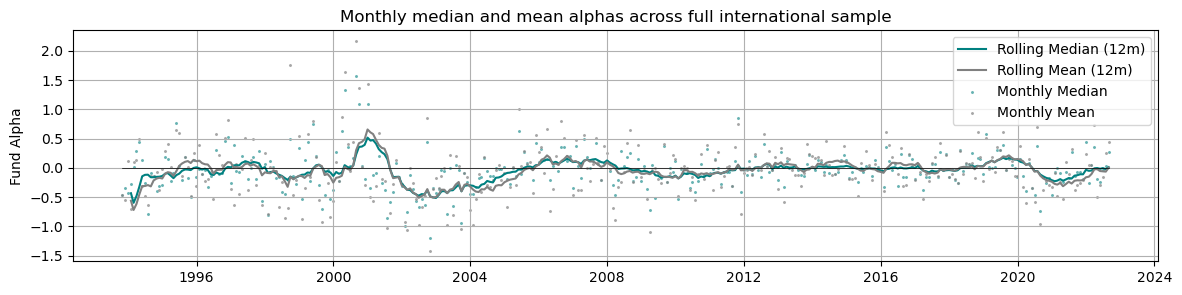

In [654]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 3))
sns.lineplot(x=alphas_plot_df.index, y='median_all_rolling', data=alphas_plot_df, color='teal', label='Rolling Median (12m)')
sns.lineplot(x=alphas_plot_df.index, y='mean_all_rolling', data=alphas_plot_df, color='grey', label='Rolling Mean (12m)')

lineplot1 = sns.scatterplot(x=alphas_plot_df.index, y='median_all', data=alphas_plot_df, color='teal', s=5, alpha=0.6, label='Monthly Median')
#lineplot1.lines[2].set_alpha(0.4)
lineplot1 = sns.scatterplot(x=alphas_plot_df.index, y='mean_all', data=alphas_plot_df, color='grey', s=5, alpha=0.7, label='Monthly Mean')
#lineplot1.lines[3].set_alpha(0.4)

sns.lineplot(x=alphas_plot_df.index, y=0, data=alphas_plot_df, color='black', linewidth = 0.5)
plt.legend()
# Add title and labels
plt.title('Monthly median and mean alphas across full international sample')
#plt.xlabel('X-axis')
plt.ylabel('Fund Alpha')
plt.grid()
plt.savefig('C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\factors_and_alphas\\full_sample_alpha_plot.png', dpi=300,  bbox_inches='tight')  # Save the plot with higher DPI



### US sample Alpha Plot


In [648]:
### readin in country-fun mapping
country_info = pd.read_excel('C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\fund_country_info\\fund_country_invested_mapping.xlsx')
country_info.head()

#slice to USA
US_funds = country_info[country_info[0] == 'United States']
US_funds_id = US_funds.iloc[:,0]
US_funds_id


# Filter the dataframe based on the index values
US_alphas = alpha_df[alpha_df.index.isin(list(US_funds_id))]
US_alphas.to_excel('US_alphas.xlsx')


In [649]:
alphas_mean_us = US_alphas.mean()
US_alphas_df = pd.DataFrame(alphas_mean_us)
US_alphas_df['median_all'] = US_alphas.median()
US_alphas_df.rename(columns={0: 'mean_all'}, inplace = True)
US_alphas_df['mean_all_rolling'] = US_alphas_df['mean_all'].rolling(12).mean()
US_alphas_df['median_all_rolling'] = US_alphas_df['median_all'].rolling(12).mean()
#define where to start the plot
US_alphas_df = US_alphas_df.iloc[165:]

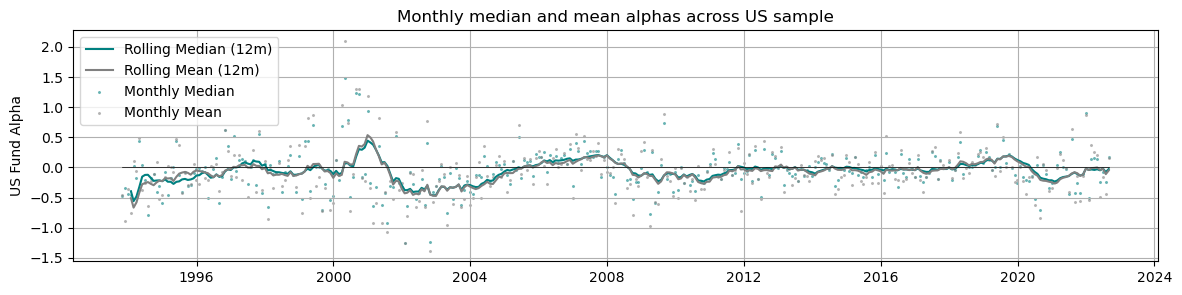

In [655]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(14, 3))
sns.lineplot(x=US_alphas_df.index, y='median_all_rolling', data=US_alphas_df, color='teal', label='Rolling Median (12m)')
sns.lineplot(x=US_alphas_df.index, y='mean_all_rolling', data=US_alphas_df, color='grey', label='Rolling Mean (12m)')

lineplot1 = sns.scatterplot(x=US_alphas_df.index, y='median_all', data=US_alphas_df, color='teal', s=5, alpha=0.6, label='Monthly Median')
#lineplot1.lines[2].set_alpha(0.4)
lineplot1 = sns.scatterplot(x=US_alphas_df.index, y='mean_all', data=US_alphas_df, color='grey', s=5, alpha=0.6, label='Monthly Mean')
#lineplot1.lines[3].set_alpha(0.4)

sns.lineplot(x=US_alphas_df.index, y=0, data=US_alphas_df, color='black', linewidth = 0.5)
plt.legend()
# Add title and labels
plt.title('Monthly median and mean alphas across US sample')
#plt.xlabel('X-axis')
plt.ylabel('US Fund Alpha')
plt.grid()
plt.savefig('C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\factors_and_alphas\\US_sample_alpha_plot.png', dpi=300,  bbox_inches='tight')  # Save the plot with higher DPI


In [622]:
import sys
!{sys.executable} -m pip install pandas tabulate


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [634]:
from tabulate import tabulate

# Calculate summary statistics
summary = US_alphas_df.loc[:,['mean_all', 'median_all']].describe().transpose()

# Convert summary to LaTeX table
latex_table = tabulate(summary, headers='keys', tablefmt='latex')

# Print the LaTeX table
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\hline
            &   count &       mean &      std &      min &       25\% &        50\% &      75\% &     max \\
\hline
 mean\_all   &     347 & -0.0689778 & 0.399569 & -1.38138 & -0.278967 & -0.0868217 & 0.131391 & 2.1007  \\
 median\_all &     347 & -0.0566644 & 0.326993 & -1.24781 & -0.230678 & -0.0730175 & 0.124186 & 1.47733 \\
\hline
\end{tabular}


In [635]:
alphas_plot_df
from tabulate import tabulate

# Calculate summary statistics
summary = alphas_plot_df.loc[:,['mean_all', 'median_all']].describe().transpose()

# Convert summary to LaTeX table
latex_table = tabulate(summary, headers='keys', tablefmt='latex')

# Print the LaTeX table
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\hline
            &   count &       mean &      std &      min &       25\% &        50\% &      75\% &     max \\
\hline
 mean\_all   &     347 & -0.0482098 & 0.445624 & -1.41645 & -0.297773 & -0.0652236 & 0.186006 & 2.17096 \\
 median\_all &     347 & -0.0464216 & 0.322996 & -1.19738 & -0.206176 & -0.0488797 & 0.115725 & 1.57063 \\
\hline
\end{tabular}


In [ ]:

#F0GBR04URR
combined_transposed = combined.T

# Iterate over the columns in the smaller DataFrame
for col in combined_transposed.columns:
    # Copy the value from the smaller DataFrame to the larger DataFrame
    alpha_df.loc['F0GBR04URR', col] = combined_transposed.loc['Alpha', col]

In [548]:
filtered_df

Category,AsPac,Emerge,Europe,Jap,NA,US,SecID
date,,,,,,,
1980-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,FOUSA00BH9
1980-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,F0GBR06HWW
1980-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,FOUSA00FQB
1980-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,F0GBR04DD8
1980-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,FOUSA00C6V
...,...,...,...,...,...,...,...
2022-08-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,F00000PT0Z
2022-08-31,0.000000,92.875000,0.000000,0.000000,0.000000,0.00000,F00000ZBDK
2022-08-31,0.000000,3.609375,3.289062,0.000000,2.650391,89.06250,F0GBR04QTD


In [547]:
alpha_df.index

Index(['FOUSA05FHG', 'FOUSA00J9X', 'F000013CFH', 'FOUSA00G0V', 'F000005H3V',
       'F0GBR04ETI', 'FOUSA05DQI', 'F000005EU3', 'F0000045SF', 'F0GBR06XGX',
       ...
       'F00000YQYE', 'F0000100IQ', 'F0GBR06B82', 'FOUSA00OAL', 'F0GBR04NXK',
       'F0GBR066PV', 'F000000QXF', 'F0GBR04C7T', 'F0GBR04D5H', 'F00000NBJ8'],
      dtype='object', length=21327)

In [540]:
summed_up_exposures[summed_up_exposures['SecID']=='FOUSA05FHG'].sum(axis = 1)

C:\Users\manue\AppData\Local\Temp\ipykernel_14164\2454267257.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  summed_up_exposures[summed_up_exposures['SecID']=='FOUSA05FHG'].sum(axis = 1)


date
1982-11-30     0.0
1982-12-31     0.0
1983-01-31     0.0
1983-02-28     0.0
1983-03-31     0.0
              ... 
2016-07-31     0.0
2016-08-31     0.0
2016-09-30    97.0
2016-10-31     0.0
2016-11-30     0.0
Length: 409, dtype: float16

,1980-01-31,1980-02-29,1980-03-31,1980-04-30,1980-05-31,1980-06-30,1980-07-31,1980-08-31,1980-09-30,1980-10-31,...,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31
FOUSA05FHG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOUSA00J9X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F000013CFH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOUSA00G0V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F000005H3V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F0GBR066PV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F000000QXF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F0GBR04C7T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F0GBR04D5H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [533]:
alpha_df.loc['F0GBR04URR'].iloc[350:400]

2009-03-31         NaN
2009-04-30         NaN
2009-05-31         NaN
2009-06-30    2.532181
2009-07-31   -0.336645
2009-08-31   -1.781386
2009-09-30   -1.899822
2009-10-31    3.943684
2009-11-30   -0.322548
2009-12-31    0.503629
2010-01-31   -1.271126
2010-02-28         NaN
2010-03-31   -2.662564
2010-04-30    0.137227
2010-05-31   -1.497832
2010-06-30    0.264427
2010-07-31    2.512694
2010-08-31    2.363226
2010-09-30    4.850873
2010-10-31    1.644755
2010-11-30    1.999215
2010-12-31   -2.696356
2011-01-31    0.449822
2011-02-28         NaN
2011-03-31         NaN
2011-04-30         NaN
2011-05-31         NaN
2011-06-30         NaN
2011-07-31         NaN
2011-08-31         NaN
2011-09-30         NaN
2011-10-31         NaN
2011-11-30         NaN
2011-12-31         NaN
2012-01-31         NaN
2012-02-29         NaN
2012-03-31         NaN
2012-04-30         NaN
2012-05-31         NaN
2012-06-30         NaN
2012-07-31         NaN
2012-08-31         NaN
2012-09-30         NaN
2012-10-31 

In [534]:
combined_transposed.T

,return,Mkt-RF,SMB,HML,RMW,CMA,RF,WML,Alpha
2002-12-31,0.50,-2.760000,4.190000,3.240000,2.240000,0.160000,0.110000,10.970000,NaN
2003-02-28,-6.20,-3.350000,0.530000,1.660000,0.230000,-0.630000,0.090000,6.200000,NaN
2003-03-31,-4.29,-1.490000,0.860000,-0.510000,1.600000,0.530000,0.100000,2.230000,NaN
2003-04-30,10.63,13.120000,-2.250000,0.240000,-3.680000,-0.050000,0.100000,-14.470000,NaN
2003-06-30,7.52,1.170000,1.980000,0.420000,0.690000,-0.420000,0.100000,-4.680000,NaN
2003-07-31,4.06,1.710000,1.190000,3.880000,-3.590000,2.160000,0.070000,-4.590000,NaN
2003-08-31,7.83,0.190000,3.260000,0.010000,1.020000,1.060000,0.070000,-2.350000,NaN
2003-09-30,0.95,2.800000,2.820000,0.070000,0.370000,-0.110000,0.080000,0.940000,NaN
2003-10-31,7.26,6.200000,-0.810000,3.660000,-2.920000,2.250000,0.070000,5.590000,NaN
2003-11-30,3.96,4.490000,0.150000,0.410000,-0.110000,0.880000,0.070000,-0.090000,NaN


In [558]:
all_factors = pd.read_excel('C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\factors_and_alphas\\factors_df.xlsx')
all_factors.set_index('date', inplace = True)
all_factors
# Repeat each column 7 times
repeated_columns = example_fund.columns.repeat(7)
df_repeated = example_fund.reindex(columns=repeated_columns)
df_repeated

,Mkt-RF_AsPac,SMB_AsPac,HML_AsPac,RMW_AsPac,CMA_AsPac,RF_AsPac,WML_AsPac,Mkt-RF_Emerge,SMB_Emerge,HML_Emerge,...,CMA_NA,RF_NA,WML_NA,Mkt-RF_US,SMB_US,HML_US,RMW_US,CMA_US,RF_US,WML_US
date,,,,,,,,,,,,,,,,,,,,,
1959-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.79,4.32,-2.10,-0.70,-0.92,0.95,4.78
1980-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.51,1.83,1.75,-1.70,1.64,0.80,7.55
1980-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.22,-1.57,0.61,0.04,2.68,0.89,7.88
1980-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-12.90,-6.93,-1.01,1.46,-1.19,1.21,-9.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,14.18,-6.98,-3.28,1.69,-1.14,0.29,-1.36,12.55,-2.95,-3.47,...,2.54,0.29,-2.38,4.60,-2.67,1.38,6.01,3.11,0.29,-2.01
2022-12-31,0.79,-0.73,6.33,-1.71,5.31,0.33,-3.22,-1.58,1.77,-0.53,...,NaN,NaN,NaN,-6.41,-0.16,1.32,0.09,4.19,0.33,4.52
2023-01-31,7.09,-1.28,-4.61,1.53,-3.97,0.35,-1.88,6.27,-0.31,-3.43,...,NaN,NaN,NaN,6.65,4.43,-4.05,-2.62,-4.53,0.35,-15.98


### Merging

In [705]:
# Reset the index to convert the identifiers into a column
alphas_reset = alpha_df.reset_index()

# Melt the dataframe to transform columns into rows
melted_df = pd.melt(alphas_reset, id_vars='index', var_name='Date', value_name='Alpha36m')

# Rename the columns
melted_df.columns = ['SecID', 'date', 'Alpha']
melted_df.drop_duplicates()

,SecID,date,Alpha
0,FOUSA05FHG,1980-01-31,NaN
1,FOUSA00J9X,1980-01-31,NaN
2,F000013CFH,1980-01-31,NaN
3,FOUSA00G0V,1980-01-31,NaN
4,F000005H3V,1980-01-31,NaN
...,...,...,...
10919419,F0GBR066PV,2022-08-31,NaN
10919420,F000000QXF,2022-08-31,NaN
10919421,F0GBR04C7T,2022-08-31,0.885782
10919422,F0GBR04D5H,2022-08-31,NaN


In [706]:
melted_df.iloc[-100:]

,SecID,date,Alpha
10919324,F0000008ES,2022-08-31,-0.533217
10919325,F0GBR04FKU,2022-08-31,NaN
10919326,F000002LCJ,2022-08-31,NaN
10919327,FOUSA00OV6,2022-08-31,NaN
10919328,F000011G60,2022-08-31,1.517294
...,...,...,...
10919419,F0GBR066PV,2022-08-31,NaN
10919420,F000000QXF,2022-08-31,NaN
10919421,F0GBR04C7T,2022-08-31,0.885782
10919422,F0GBR04D5H,2022-08-31,NaN


In [695]:
data

,SecID,#_Stock_Holdings_Short,%_Asset_In_Top_10_Holdings,Cash_%_Net,Eq_Country_Australia_Net,Eq_Country_Brazil_Net,Eq_Country_Canada_Net,Eq_Country_China_Net,Eq_Country_France_Net,Eq_Country_Germany_Net,...,Eq_Type_Distressed_Net,Eq_Type_Other_Net,Eq_Type_Speculative_Growth_Net,Rating,returns,Portfolio_Corporate_Sustainability_Score,Eq_Stylebox_Long,Financial_Health_Grade_Long,Growth_Grade_Long,Profitability_Grade_Long
date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,FOUSA00BH9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0569,NaN,NaN,NaN,NaN,NaN
1980-01-31,F0GBR06HWW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.6882,NaN,NaN,NaN,NaN,NaN
1980-01-31,FOUSA00FQB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.1295,NaN,NaN,NaN,NaN,NaN
1980-01-31,F0GBR04DD8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.1186,NaN,NaN,NaN,NaN,NaN
1980-01-31,FOUSA00C6V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.1214,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,F00000ZBDK,0.0,100.1875,0.199951,0.0,92.875000,0.000000,0.000000,0.0,0.000000,...,NaN,NaN,NaN,NaN,0.0725,NaN,Mid Growth,C-,B-,C
2022-08-31,F0GBR04QTD,NaN,36.4375,1.389648,0.0,0.000000,2.650391,0.000000,0.0,0.000000,...,0.000000,9.632812,3.750000,NaN,-0.0855,NaN,Large Blend,B,B-,C+
2022-08-31,F00000WC0Z,NaN,45.2500,1.269531,0.0,0.000000,0.000000,3.320312,0.0,5.160156,...,0.000000,0.000000,0.000000,3.0,-0.0321,NaN,Large Value,B+,C+,B-


In [707]:
data_test = data.reset_index(drop=False)
data_test.date

0         1980-01-31
1         1980-01-31
2         1980-01-31
3         1980-01-31
4         1980-01-31
             ...    
3737290   2022-08-31
3737291   2022-08-31
3737292   2022-08-31
3737293   2022-08-31
3737294   2022-08-31
Name: date, Length: 3737295, dtype: datetime64[ns]

In [708]:
data_test

,date,SecID,#_Stock_Holdings_Short,%_Asset_In_Top_10_Holdings,Cash_%_Net,Eq_Country_Australia_Net,Eq_Country_Brazil_Net,Eq_Country_Canada_Net,Eq_Country_China_Net,Eq_Country_France_Net,...,Eq_Type_Distressed_Net,Eq_Type_Other_Net,Eq_Type_Speculative_Growth_Net,Rating,returns,Portfolio_Corporate_Sustainability_Score,Eq_Stylebox_Long,Financial_Health_Grade_Long,Growth_Grade_Long,Profitability_Grade_Long
0,1980-01-31,FOUSA00BH9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0569,NaN,NaN,NaN,NaN,NaN
1,1980-01-31,F0GBR06HWW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.6882,NaN,NaN,NaN,NaN,NaN
2,1980-01-31,FOUSA00FQB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.1295,NaN,NaN,NaN,NaN,NaN
3,1980-01-31,F0GBR04DD8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.1186,NaN,NaN,NaN,NaN,NaN
4,1980-01-31,FOUSA00C6V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.1214,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3737290,2022-08-31,F00000ZBDK,0.0,100.1875,0.199951,0.0,92.875000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,0.0725,NaN,Mid Growth,C-,B-,C
3737291,2022-08-31,F0GBR04QTD,NaN,36.4375,1.389648,0.0,0.000000,2.650391,0.000000,0.0,...,0.000000,9.632812,3.750000,NaN,-0.0855,NaN,Large Blend,B,B-,C+
3737292,2022-08-31,F00000WC0Z,NaN,45.2500,1.269531,0.0,0.000000,0.000000,3.320312,0.0,...,0.000000,0.000000,0.000000,3.0,-0.0321,NaN,Large Value,B+,C+,B-
3737293,2022-08-31,F000015O3W,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.0410,NaN,NaN,NaN,NaN,NaN


In [709]:
data_test = data_test.merge(melted_df, on=['SecID', 'date'])
data_test.set_index('date', drop = True, inplace = True)


TypeError: to_excel() missing 1 required positional argument: 'excel_writer'

In [711]:
data_test.to_pickle('full_data_with_alpha.pkl')


In [713]:
full_data = pd.read_pickle('C:\\Users\\manue\\switchdrive\\Mutual Funds Project\\data\\pickle_files\\full_data_with_alpha.pkl')

In [716]:
full_data.iloc[2000100:2000200]

,SecID,#_Stock_Holdings_Short,%_Asset_In_Top_10_Holdings,Cash_%_Net,Eq_Country_Australia_Net,Eq_Country_Brazil_Net,Eq_Country_Canada_Net,Eq_Country_China_Net,Eq_Country_France_Net,Eq_Country_Germany_Net,...,Eq_Type_Other_Net,Eq_Type_Speculative_Growth_Net,Rating,returns,Portfolio_Corporate_Sustainability_Score,Eq_Stylebox_Long,Financial_Health_Grade_Long,Growth_Grade_Long,Profitability_Grade_Long,Alpha
date,,,,,,,,,,,,,,,,,,,,,
2011-03-31,FOUSA06MFY,NaN,12.203125,0.000000,3.419922,4.761719,2.740234,4.398438,5.261719,5.078125,...,NaN,NaN,3.0,0.0013,NaN,Large Blend,B,C+,C,-0.483095
2011-03-31,F000003XLN,NaN,49.062500,5.980469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,0.1118,NaN,Large Blend,C+,B,C,NaN
2011-03-31,F000002BJJ,0.0,33.031250,12.882812,4.328125,0.669922,3.990234,0.000000,8.742188,5.339844,...,0.000000,2.240234,NaN,0.0183,NaN,Large Value,A-,C+,C+,2.612436
2011-03-31,F0GBR06QLX,0.0,54.718750,2.769531,0.000000,0.000000,0.000000,0.000000,95.500000,0.000000,...,NaN,NaN,3.0,0.0177,NaN,Large Value,C,C+,C-,NaN
2011-03-31,F0GBR06UGQ,NaN,26.875000,0.930176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,5.0,-0.0065,NaN,Small Blend,NaN,NaN,C+,-2.938042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-03-31,FOUSA056SL,NaN,25.640625,0.000000,0.000000,0.000000,8.257812,0.000000,0.000000,0.000000,...,1.320312,0.000000,2.0,0.0235,NaN,Small Growth,B,B-,C+,NaN
2011-03-31,F0GBR064TY,NaN,57.250000,1.099609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,2.0,0.0303,NaN,Large Growth,B+,B,C,-1.9245
2011-03-31,FOUSA05BY6,NaN,35.437500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.058594,3.869141,3.0,0.0018,NaN,Large Value,B,C+,C+,0.496679
